In [33]:
import pandas as pd
import numpy as np
import random
from glob import glob
import os
import re

import matplotlib.pyplot as plt

from graphviz import Source
import networkx as nx

from networkx.drawing.nx_agraph import graphviz_layout, to_agraph

In [34]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [35]:
# Get mutations probabilities from scRNAseq data
probabilities = pd.read_csv('../../data/YFV2001_matrix_output/0.0556.csv', sep=' ', header=None).stack().loc[lambda x : x >= 0.5].array


## Generate the ground truth pmats

In [36]:
def mutations_data(clones, cells_per_clone, n_mutations, low_prob):
    np.random.seed(42)
    
    c = [f'c{w+1}' for w in range(clones)]
    s = [f's{w+1}' for w in range(cells_per_clone)]
    mux = pd.MultiIndex.from_product([c, s])
    
    n_rows = clones * n_mutations
    
    #Generate a dataframe with with default value
    gt = pd.DataFrame(low_prob, index=np.arange(n_rows) // n_mutations, columns=mux)
    
    # random assign 'X' for mutation by random index with no repeat
    for c, i in zip(gt.columns.levels[0], 
                    np.random.choice(np.unique(gt.index), clones, replace=False)):
        gt.loc[i, c] = 'X' 
    
    
    gt.columns = gt.columns.map(lambda clones: f'{clones[0]}_{clones[1]}')
    gt = gt.reset_index(drop=True)

    return gt

In [37]:
def generate_pmat(clones, cells_per_clone, n_mutations, low_prob):
    
    # clonal mutations
    clonal = mutations_data(clones, cells_per_clone, n_mutations, low_prob)
    cells = list(clonal.columns)
    n_clonal_muts = len(clonal)

    
    #subclone1
    subclones = clones*2
    cells_per_subclones = cells_per_clone//2
    #n_rows = subclones1 * n_mutations
    subclonal = mutations_data(subclones, cells_per_subclones, n_mutations, low_prob)
    subclonal.columns = cells
    n_subclonal_muts = len(subclonal)
    
    frames = [clonal, subclonal]
    pmat = pd.concat(frames, ignore_index=True)
    
    # Replace 'X' by sampling from mutations probabilities observed in scRNAseq
    pmat[pmat == 'X'] = np.random.choice(probabilities, size=pmat.shape, replace=True)
    
    # Add bulk
    #pmat.insert(loc=0, column='bulk', value=0.0001)
    
    pmat = pmat.replace(1.0, 0.99999)
    
    shape = pmat.shape
    
    return pmat, shape, n_clonal_muts, n_subclonal_muts

### Tree 1

In [38]:
clones = 10
cells_per_clone = 10
n_mutations = 1
low_prob = 0.0001 # no mutation

tree1, shape, n_clonal_muts, n_subclonal_muts = generate_pmat(clones, cells_per_clone, n_mutations, low_prob)


In [39]:
if 1.0 in tree1.values:
    print("\nThis value exists in Dataframe")
else :
    print("\nThis value does not exists in Dataframe")


This value does not exists in Dataframe


### Tree 2, 3, 4, 5

In [40]:
# tree 1
print('tree1 shape: ' + str(tree1.shape))

# remove half of the subclonal muts
tree2 = tree1.iloc[:-(int(n_subclonal_muts/2))]
print('tree2 shape: ' + str(tree2.shape))

# remove all subclonal muts
tree3 = tree1.iloc[:-n_subclonal_muts]
print('tree3 shape: ' + str(tree3.shape))

# remove all subclonal muts and 2 clonal muts
tree4 = tree1.iloc[:-(int(n_subclonal_muts+n_clonal_muts*0.2))]
print('tree4 shape: ' + str(tree4.shape))

# remove all subclonal muts and 5 clonal muts
tree5 = tree1.iloc[:-(int(n_subclonal_muts+n_clonal_muts*0.5))]
print('tree5 shape: ' + str(tree5.shape))

tree1 shape: (30, 100)
tree2 shape: (20, 100)
tree3 shape: (10, 100)
tree4 shape: (8, 100)
tree5 shape: (5, 100)


### Save ground truth pmats

In [41]:
matrix_path = '../../data/simulations_matrix_output/ground_truth/tree1.csv'
tree1.to_csv(matrix_path, index=False, sep=' ', header= False)

matrix_path = '../../data/simulations_matrix_output/ground_truth/tree2.csv'
tree2.to_csv(matrix_path, index=False, sep=' ', header= False)

matrix_path = '../../data/simulations_matrix_output/ground_truth/tree3.csv'
tree3.to_csv(matrix_path, index=False, sep=' ', header= False)

matrix_path = '../../data/simulations_matrix_output/ground_truth/tree4.csv'
tree4.to_csv(matrix_path, index=False, sep=' ', header= False)

matrix_path = '../../data/simulations_matrix_output/ground_truth/tree5.csv'
tree5.to_csv(matrix_path, index=False, sep=' ', header= False)

### Check ground truth trees

In [42]:
# Checking tree5

tree = tree5
experiment = 'tree5'

SCITE_ground_truth_path = '../../../mt-SCITE/mt-SCITE_output/Simulations/ground_truth/'
std_path = 'stdout'

try:
    os.makedirs(SCITE_ground_truth_path + std_path)
except FileExistsError :
    pass
except :
    raise


# Run mt-SCITE
tree_path = SCITE_ground_truth_path + f'{experiment}'
stdout_path = SCITE_ground_truth_path + std_path + '/' + f'{experiment}_stdout.txt'
n = tree.shape[0]
m = tree.shape[1]
#print(tree_path)

! ../../../mt-SCITE/mt-SCITE/scite -i $matrix_path -n $n -m $m -r 1 -l 200000 -fd 0.0001 -ad 0.0001 -cc 0.0 -s -a -o $tree_path 1> $stdout_path


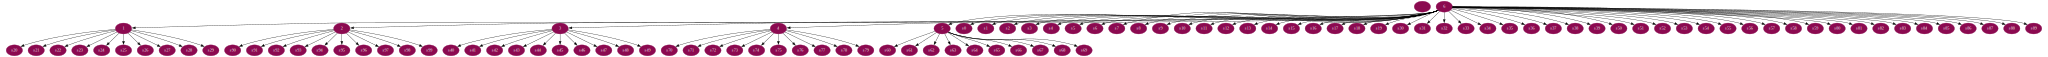

In [43]:
tree_filename = f'{tree_path}_map0.gv'
tree = nx.drawing.nx_pydot.read_dot(tree_filename)

g = to_agraph(tree)
g.layout('dot')
#g.draw(f'figs/trees/{error_rate}_map{tree_number}.pdf')
Source(g)

## Add non-informative mutations

In [44]:
def add_noise(gt, ni_muts, tree, iteration):
    #np.random.seed(42)
    it = str(iteration)
    
    i_muts = len(gt)
    #print(i_muts)
    
    
    # x is n cells sharing a non-informative phylo signal
    for x in range(2, 9):

        gt_w_noise = gt.copy()
        counter = 0
        
        # i is the number of added non-informative positions
        for i in range(1, ni_muts+1):
            #print(len(gt))
            
            # until reaches the total len of the final df
            if len(gt_w_noise) != i_muts + ni_muts:
                #print('i_muts and ni_muts = ' + str(i_muts + ni_muts))
                #print('the length before ni muts = ' + str(len(gt_w_noise)))
                counter+=1
                #print('n muts added = ' + str(counter))
                
                
                # add new row with low probability for mutation
                gt_w_noise.loc[-1,:] = 0.0001
                #gt_w_noise.loc[-1,:] = '.'

                # reset index
                gt_w_noise = gt_w_noise.reset_index(drop=True)

                # assign high probability to x randomly selected cells on last row
                np.random.seed(42)
                
                # TODO: sample mutations probabilities from scRNAseq
                gt_w_noise.iloc[-1:, random.sample(list(range(gt_w_noise.shape[1])), x)] = 0.99
                #print('length after ni muts = ' + str(len(gt_w_noise)))
                #print('.....')

                
                # n is number of added non-informative positions
                n = str(counter)
                
                matrix_path = '../../data/simulations_matrix_output/non-informative/' + tree + '/' + tree + '_' + str(x) + '_cells_' + n + '_pos_' + it + '_iter.csv'
                gt_w_noise.to_csv(matrix_path, index=False, sep=' ', header= False)
                #print(len(gt_w_noise))

In [45]:
# non-informative mutations to add
ni_muts = 20

for i in range(1,101):
    add_noise(tree5, ni_muts, 'tree5', i)

In [46]:
#ni_muts = 120
#for i in range(1,11):
#    add_noise(tree1, ni_muts, 'tree1', i)

### Check tree

In [47]:
tree5_2_cells_10_pos_99_iter = pd.read_csv('../../data/simulations_matrix_output/non-informative/tree5/tree5_2_cells_10_pos_99_iter.csv', sep=' ', header=None)


In [48]:
tree5_2_cells_10_pos_99_iter.shape

(15, 100)

In [49]:
tree_name = 'tree5_2_cells_10_pos_99_iter'
matrix_path = '../../data/simulations_matrix_output/non-informative/tree5/tree5_2_cells_10_pos_99_iter.csv'

SCITE_path_manual = '../../../mt-SCITE/mt-SCITE_output/Simulations/non-informative_mutations/manual_tests/'
std_path = 'stdout'


try:
    os.makedirs(SCITE_path_manual + std_path)
except FileExistsError :
    pass
except :
    raise


# Run mt-SCITE
tree_path = SCITE_path_manual + f'{tree_name}'
stdout_path = SCITE_path_manual + std_path + '/' + f'{tree_name}_stdout.txt'

#! echo $stdout_path

! ../../../mt-SCITE/mt-SCITE/scite -i $matrix_path -n 15 -m 100 -r 1 -l 200000 -fd 0.0001 -ad 0.0001 -cc 0.0 -s -a -o $tree_path 1> $stdout_path


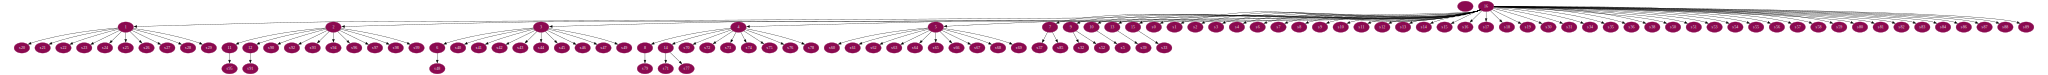

In [50]:
tree_filename = f'{tree_path}_map0.gv'
tree = nx.drawing.nx_pydot.read_dot(tree_filename)

g = to_agraph(tree)
g.layout('dot')
#g.draw(f'figs/trees/{error_rate}_map{tree_number}.pdf')
Source(g)

## Run mt-SCITE

## Tree 5

In [51]:
experiment = 'tree5'
experiment

'tree5'

In [52]:
# Check n samples
a_pmat = pd.read_csv('../../data/simulations_matrix_output/non-informative/tree5/tree5_2_cells_10_pos_99_iter.csv', sep=' ', header=None)
a_pmat.shape

(15, 100)

### Get data from pmat for tree5

In [53]:
# prepare pmat data

pmat_names = []
shapes = []

pmat_input_path = f'../../data/simulations_matrix_output/non-informative/{experiment}/'
#print(pmat_input_path)
pmats = list(glob(os.path.join(pmat_input_path, '*.csv')))
tree_name = []

for filename in sorted(pmats, key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
    name = os.path.basename(filename).split('-')[0].rsplit('.', 2)[0]
    #print(name)
    pmat_names.append(name)
    df = pd.read_csv(filename, sep=' ', header=None)
    shapes.append(len(df))

# make df with pmat info
pmat_data = pd.DataFrame(
    {'pmat_names': pmat_names,
     'len': shapes,
    })


# add some info
pmat_data['tree_name'] = pmat_data.pmat_names.str[:5]
pmat_data['cells_w_ni'] = pmat_data.pmat_names.str[6:13]
pmat_data['iter'] = pmat_data['pmat_names'].str.split('_', n = 5).str[5]
pmat_data["iter_directory"] = pmat_data["tree_name"] + '_' +pmat_data["iter"]

#len(pmat_names)
pmat_data.head(11)
    

,pmat_names,len,tree_name,cells_w_ni,iter,iter_directory
0,tree5_2_cells_1_pos_1_iter,6,tree5,2_cells,1_iter,tree5_1_iter
1,tree5_2_cells_1_pos_2_iter,6,tree5,2_cells,2_iter,tree5_2_iter
2,tree5_2_cells_1_pos_3_iter,6,tree5,2_cells,3_iter,tree5_3_iter
3,tree5_2_cells_1_pos_4_iter,6,tree5,2_cells,4_iter,tree5_4_iter
4,tree5_2_cells_1_pos_5_iter,6,tree5,2_cells,5_iter,tree5_5_iter
5,tree5_2_cells_1_pos_6_iter,6,tree5,2_cells,6_iter,tree5_6_iter
6,tree5_2_cells_1_pos_7_iter,6,tree5,2_cells,7_iter,tree5_7_iter
7,tree5_2_cells_1_pos_8_iter,6,tree5,2_cells,8_iter,tree5_8_iter
8,tree5_2_cells_1_pos_9_iter,6,tree5,2_cells,9_iter,tree5_9_iter
9,tree5_2_cells_1_pos_10_iter,6,tree5,2_cells,10_iter,tree5_10_iter


### Run mt-SCITE

In [54]:
experiment

'tree5'

In [ ]:

SCITE_PATH = '../../../mt-SCITE'
PMAT_PATH = f'../../data/simulations_matrix_output/non-informative/{experiment}'
OUTPUT = f'../../../mt-SCITE/mt-SCITE_output/Simulations/non-informative_mutations/{experiment}'

n_cells = '100'

for pmat in pmat_names:
    #print(pmat)
    
    # Get number of mutations
    n = pmat_data.loc[pmat_data['pmat_names'] == pmat, 'len'].iloc[0].astype(str)
    #print(n)
    
    # folder was changed to iter_directory Get iter directory for output dir name
    iter_directory = pmat_data.loc[pmat_data['pmat_names'] == pmat, 'iter_directory'].iloc[0]
    #print(tree_folder)
    
    # Get number of added non-information mutations for output dir name
    cells_w_ni = pmat_data.loc[pmat_data['pmat_names'] == pmat, 'cells_w_ni'].iloc[0]
    #print(cells_w_ni)    
    
    try:
        os.makedirs(OUTPUT + '/' + iter_directory + '/' + cells_w_ni + '/') 
    except FileExistsError :
        pass
    except :
        raise
        
    ! $SCITE_PATH/mt-SCITE/scite -i $PMAT_PATH/$pmat\.csv -n $n -m $n_cells -r 1 -l 200000 -fd 0.0001 -ad 0.0001 -cc 0.0 -s -a -o $OUTPUT/$iter_directory/$cells_w_ni/$pmat 1> $OUTPUT/stdout/$pmat\.stdout.txt
